References: https://sanaazahra.medium.com/ocr-segmentation-with-python-code-f3251114ee48

            https://github.com/computervisionpro/yt/blob/main/line-text-segmentation/tutorial20.ipynb

            
            https://github.com/Nagakiran1/4-simple-steps-in-Builiding-OCR/blob/master/OCR_Algorithm.PNG

            
            Used chatGPT for new methods in resizing images and to learn about image segmentation

This file contains image segmentation. 
At First, I made an algo that detects every letter from a Image
Next I made a algo that detect word from a image

In [147]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [148]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

In [149]:
def numeric_to_alphabet(num):
    return chr(num + ord('A'))

In [150]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(26, activation='softmax')
])

In [151]:
model.load_weights("yash.h5")

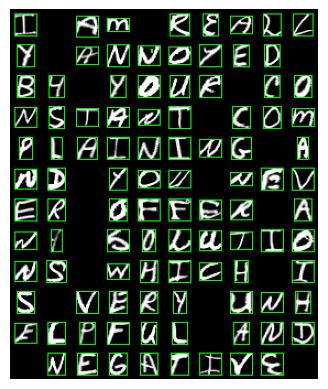

In [152]:
file = r"D:\notebooks for ML\Task 2\data\target_images\line_1.png"

# reading the image
im1 = cv2.imread(file, 0)
im = cv2.imread(file)

# Apply a binary threshold to the image
ret, thresh1 = cv2.threshold(im1, 0, 255, cv2.THRESH_BINARY)

# Finding contours
contours, hierarchy = cv2.findContours(thresh1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Drawing rectangles around the contours
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    cv2.rectangle(im, (x, y), (x + w, y + h), (0, 255, 0), 1)

#we are using matplotlib to draw/show images
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

After getting contours values, they are randomly arranged , 


so we need to sort them in a top to bottom and left to right order

first we need to sort contours in top to bottom , then we will sort in right to left

In [153]:
# function to sort contours
def sort_contours(contours, image_height, method="left-to-right-top-to-bottom"):
    if method == "left-to-right-top-to-bottom":
        # Sort by the y-coordinate first (top to bottom)
        bounding_boxes = [cv2.boundingRect(c) for c in contours]
        contours_with_boxes = sorted(zip(contours, bounding_boxes), key=lambda b: b[1][1])

        # Group contours by rows based on y-coordinate threshold
        rows = []
        current_row = []
        previous_y = -image_height  # Initialize with a large negative number

        for contour, box in contours_with_boxes:
            x, y, w, h = box
            # Threshold for grouping into the same row
            if current_row and abs(previous_y - y) > h // 2:
                rows.append(current_row)
                current_row = []

            current_row.append((contour, box))
            previous_y = y

        if current_row:
            rows.append(current_row)

        # Sort each row by x-coordinate (left to right)
        sorted_contours = []
        for row in rows:
            row = sorted(row, key=lambda b: b[1][0])
            sorted_contours.extend(row)

        return [c for c, _ in sorted_contours]

    return contours

In [154]:
contours = sort_contours(contours,im.shape[0])

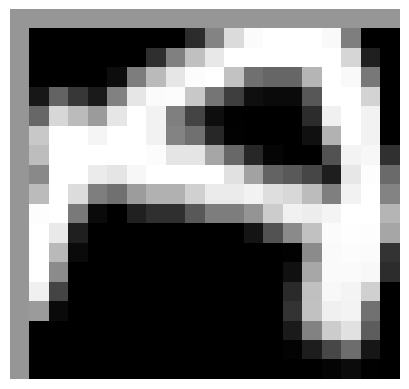

In [155]:
x, y, w, h = cv2.boundingRect(contours[1])
roi = im[y:y+h, x:x+w]
roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

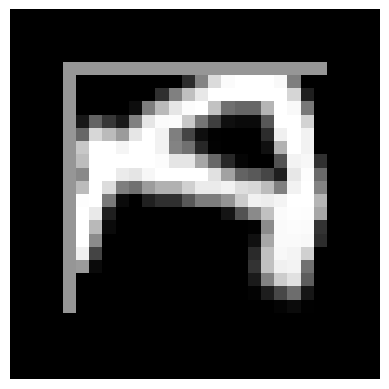

In [156]:
original_height, original_width = roi.shape

# Define the target size
target_size = 28

# Calculate the required border sizes
top_border = (target_size - original_height) // 2
bottom_border = target_size - original_height - top_border
left_border = (target_size - original_width) // 2
right_border = target_size - original_width - left_border

# Add the black border
bordered_image = cv2.copyMakeBorder(roi, top_border, bottom_border, left_border, right_border, cv2.BORDER_CONSTANT, value=0)

# showing image
plt.imshow(cv2.cvtColor(bordered_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [157]:
roi = bordered_image
image_array = np.array(roi)
image_array = image_array.reshape(-1)
image_array = image_array.reshape(1,28,28)
image_array = image_array/255.0

prediction = model.predict(image_array)
character = numeric_to_alphabet(np.argmax(prediction))

character

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


'A'

So now we are gonna implement :
1. finding contours in a image
2. making images from contours values
3. Predicting alphabets of those images

In [159]:
def letters_in_images(file,model):
    
    #############################################
    #1. Reading the image and finding contours
    ############################################
    # Read the image in grayscale and colour
    im1 = cv2.imread(file, 0)
    im = cv2.imread(file)

    # Apply a binary threshold to the image
    ret, thresh1 = cv2.threshold(im1, 0, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, hierarchy = cv2.findContours(thresh1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    #sorting contours
    contours = sort_contours(contours,im.shape[0])

    ##################################################################################
    #Going through every contour and making a new image from contour values 
    ################################################################################3###
    ans = []
    for i in range(len(contours)):
        x, y, w, h = cv2.boundingRect(contours[i])
        roi = im[y:y+h, x:x+w]
        roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        
        ################
        #resizing image
        ###############
        original_height, original_width = roi.shape

        # Define the target size
        target_size = 28

        # Calculate the required border sizes
        top_border = (target_size - original_height) // 2
        bottom_border = target_size - original_height - top_border
        left_border = (target_size - original_width) // 2
        right_border = target_size - original_width - left_border

        # Add the black border
        bordered_image = cv2.copyMakeBorder(roi, top_border, bottom_border, left_border, right_border, cv2.BORDER_CONSTANT, value=0)

        ##################
        #predicting letter
        ################
        roi = bordered_image
        image_array = np.array(roi)
        image_array = image_array.reshape(-1)
        image_array = image_array.reshape(1,28,28)
        image_array = image_array/255.0

        prediction = model.predict(image_array)
        character = numeric_to_alphabet(np.argmax(prediction))

        ans.append(character)

    return ans

Running my function on target images

In [160]:
ans = letters_in_images( r"D:\notebooks for ML\Task 2\data\target_images\line_1.png",model) 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

In [161]:
print(ans)

['I', 'A', 'M', 'R', 'E', 'A', 'L', 'L', 'Y', 'A', 'N', 'N', 'O', 'Y', 'E', 'D', 'S', 'B', 'Y', 'Y', 'O', 'U', 'R', 'C', 'O', 'N', 'S', 'T', 'A', 'N', 'T', 'C', 'O', 'M', 'P', 'L', 'A', 'I', 'N', 'I', 'N', 'G', 'A', 'N', 'D', 'Y', 'O', 'U', 'N', 'E', 'V', 'E', 'R', 'O', 'F', 'F', 'E', 'R', 'A', 'N', 'Y', 'S', 'O', 'L', 'U', 'T', 'I', 'O', 'N', 'S', 'W', 'H', 'I', 'C', 'H', 'I', 'S', 'V', 'E', 'R', 'Y', 'U', 'N', 'H', 'E', 'L', 'P', 'F', 'U', 'L', 'A', 'N', 'D', 'N', 'E', 'G', 'A', 'T', 'I', 'V', 'E']


In [162]:
ans = letters_in_images( r"D:\notebooks for ML\Task 2\data\target_images\line_2.png",model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

In [163]:
print(ans)

['I', 'T', 'I', 'S', 'F', 'R', 'U', 'S', 'T', 'R', 'A', 'T', 'I', 'N', 'G', 'T', 'H', 'A', 'T', 'Y', 'O', 'U', 'N', 'E', 'V', 'E', 'R', 'P', 'A', 'Y', 'A', 'T', 'T', 'E', 'N', 'T', 'I', 'O', 'N', 'D', 'U', 'R', 'I', 'N', 'G', 'D', 'I', 'S', 'C', 'U', 'S', 'S', 'I', 'O', 'N', 'S', 'A', 'N', 'D', 'Y', 'O', 'U', 'R', 'L', 'A', 'C', 'K', 'O', 'F', 'F', 'O', 'C', 'U', 'S', 'I', 'S', 'R', 'E', 'A', 'L', 'L', 'Y', 'A', 'F', 'F', 'E', 'C', 'T', 'I', 'N', 'G', 'O', 'U', 'R', 'P', 'R', 'O', 'G', 'R', 'E', 'S', 'S']


In [164]:
ans = letters_in_images( r"D:\notebooks for ML\Task 2\data\target_images\line_3.png",model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

In [165]:
print(ans)

['I', 'A', 'M', 'D', 'E', 'L', 'I', 'G', 'H', 'T', 'E', 'D', 'B', 'Y', 'Y', 'O', 'U', 'R', 'F', 'R', 'I', 'E', 'N', 'D', 'L', 'I', 'N', 'E', 'S', 'S', 'A', 'N', 'D', 'Y', 'O', 'U', 'A', 'L', 'W', 'A', 'Y', 'S', 'M', 'A', 'K', 'E', 'E', 'V', 'E', 'R', 'Y', 'O', 'N', 'E', 'F', 'E', 'E', 'L', 'W', 'E', 'L', 'C', 'O', 'M', 'E', 'W', 'H', 'I', 'C', 'H', 'F', 'O', 'S', 'T', 'E', 'R', 'S', 'A', 'S', 'E', 'N', 'S', 'E', 'O', 'F', 'C', 'O', 'M', 'M', 'U', 'N', 'I', 'T', 'Y']


In [166]:
ans = letters_in_images( r"D:\notebooks for ML\Task 2\data\target_images\line_4.png",model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

In [167]:
print(ans)

['I', 'T', 'I', 'S', 'W', 'O', 'N', 'D', 'E', 'R', 'F', 'U', 'L', 'T', 'H', 'A', 'T', 'Y', 'O', 'U', 'A', 'L', 'W', 'A', 'Y', 'S', 'S', 'H', 'O', 'W', 'K', 'I', 'N', 'D', 'N', 'E', 'S', 'S', 'A', 'N', 'D', 'Y', 'O', 'U', 'R', 'E', 'M', 'P', 'A', 'T', 'H', 'Y', 'T', 'O', 'W', 'A', 'R', 'D', 'S', 'O', 'T', 'H', 'E', 'R', 'S', 'I', 'S', 'T', 'R', 'U', 'L', 'Y', 'H', 'E', 'A', 'R', 'T', 'W', 'A', 'R', 'M', 'I', 'N', 'G', 'S', 'A', 'N', 'D', 'A', 'P', 'P', 'R', 'E', 'C', 'I', 'A', 'T', 'E', 'D']


In [168]:
ans = letters_in_images( r"D:\notebooks for ML\Task 2\data\target_images\line_5.png",model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━

In [169]:
print(ans)

['Y', 'O', 'U', 'R', 'A', 'N', 'A', 'L', 'Y', 'S', 'I', 'S', 'O', 'F', 'T', 'H', 'E', 'D', 'A', 'T', 'A', 'W', 'A', 'S', 'A', 'C', 'C', 'U', 'R', 'A', 'T', 'E', 'A', 'N', 'D', 'W', 'E', 'L', 'L', 'P', 'R', 'E', 'S', 'E', 'N', 'T', 'E', 'D', 'P', 'R', 'O', 'V', 'I', 'D', 'I', 'N', 'G', 'A', 'C', 'L', 'E', 'A', 'R', 'U', 'N', 'D', 'E', 'R', 'S', 'T', 'A', 'N', 'D', 'I', 'N', 'G', 'O', 'F', 'T', 'H', 'E', 'T', 'R', 'E', 'N', 'D', 'S', 'A', 'N', 'D', 'P', 'A', 'T', 'T', 'E', 'R', 'N', 'S']


In [170]:
ans = letters_in_images( r"D:\notebooks for ML\Task 2\data\target_images\line_6.png",model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━

In [171]:
print(ans)

['T', 'H', 'E', 'M', 'E', 'E', 'T', 'I', 'N', 'G', 'M', 'I', 'N', 'U', 'T', 'E', 'S', 'Y', 'O', 'U', 'P', 'R', 'E', 'P', 'A', 'R', 'E', 'D', 'W', 'E', 'R', 'E', 'D', 'E', 'F', 'T', 'A', 'I', 'L', 'E', 'D', 'A', 'N', 'D', 'W', 'E', 'L', 'L', 'O', 'R', 'G', 'A', 'N', 'I', 'Z', 'E', 'D', 'A', 'C', 'C', 'U', 'R', 'A', 'T', 'E', 'L', 'Y', 'R', 'E', 'F', 'L', 'E', 'C', 'I', 'N', 'G', 'T', 'H', 'T', 'E', 'D', 'I', 'S', 'C', 'U', 'S', 'S', 'I', 'O', 'N', 'S', 'A', 'N', 'D', 'D', 'E', 'C', 'I', 'S', 'I', 'O', 'N', 'S', 'M', 'A', 'D', 'E']


this algo was able to identify all letters from target images in left to right order

In [ ]:
################################
## Here I manually kept a threshold value 
################################

In [122]:
def text_from_image(file,model,threshold_1,threshold_2):
    
    #############################################
    #1. Reading the image and finding contours
    ############################################
    # Read the image in grayscale and colour
    im1 = cv2.imread(file, 0)
    im = cv2.imread(file)

    # Apply a binary threshold to the image
    ret, thresh1 = cv2.threshold(im1, 0, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, hierarchy = cv2.findContours(thresh1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    #sorting contours
    contours = sort_contours(contours,im.shape[0])

    ##################################################################################
    #Going through every contour and making a new image from contour values 
    ################################################################################3###
    x1, y1, w1, h1 = cv2.boundingRect(contours[0])
    ans = ""
    for i in range(len(contours)):
        x, y, w, h = cv2.boundingRect(contours[i])
        roi = im[y:y+h, x:x+w]

        if x < x1:
            if 280 - x1-w1 + x > threshold_2:
                ans += " "
        else:
            if(abs(x - x1)) > threshold_1:
                ans += " "

        x1 = x
        y1 = y
        roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        
        ################
        #resizing image
        ###############
        original_height, original_width = roi.shape

        # Define the target size
        target_size = 28

        # Calculate the required border sizes
        top_border = (target_size - original_height) // 2
        bottom_border = target_size - original_height - top_border
        left_border = (target_size - original_width) // 2
        right_border = target_size - original_width - left_border

        # Add the black border
        bordered_image = cv2.copyMakeBorder(roi, top_border, bottom_border, left_border, right_border, cv2.BORDER_CONSTANT, value=0)

        ##################
        #predicting letter
        ################
        roi = bordered_image
        image_array = np.array(roi)
        image_array = image_array.reshape(-1)
        image_array = image_array.reshape(1,28,28)
        image_array = image_array/255.0

        prediction = model.predict(image_array)
        character = numeric_to_alphabet(np.argmax(prediction))

        ans += character

    return ans

In [123]:
print(text_from_image( r"D:\notebooks for ML\Task 2\data\target_images\line_1.png",model,50,25))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━

Required Answer : Answer: I AM REALLY ANNOYED BY YOUR CONSTANT COMPLAINING AND YOU NEVER OFFER ANY SOLUTIONS WHICH IS VERY UNHELPFUL AND NEGATIVE



Answer: I AM REALLY ANNOYED S BY YOUR CONSTANT COMPLAINING AND YOU NEVER OFFER ANY SOLUTIONS WHICH IS VERY UNHELPFUL AND NEGATIVE

In [124]:
print(text_from_image( r"D:\notebooks for ML\Task 2\data\target_images\line_2.png",model,50,25))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━

Required Answer : IT IS FRUSTRATING THAT YOU NEVER PAY ATTENTION DURING DISCUSSIONS AND YOUR LACK OF FOCUS IS REALLY AFFECTING OUR PROGRESS



Answer: IT IS FRUSTRATING THAT YOU NEVER PAY ATTENTION DURING DISCUSSIONS AND YOUR LACK OF FOCUS IS REALLY AFFECTING OUR PROGRESS

In [125]:
print(text_from_image( r"D:\notebooks for ML\Task 2\data\target_images\line_3.png",model,50,25))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━

Required Answer : I AM DELIGHTED BY YOUR FRIENDLINESS AND YOU ALWAYS MAKE EVERYONE FEEL WELCOME WHICH FOSTERS A SENSE OF COMMUNITY



Answer: I AM DELIGHTED BY YOUR FRIENDLINESS AND YOU ALWAYS MAKE EVERYONE FEEL WELCOME WHICH FOSTERS A SENSE OF COMMUNITY

In [126]:
print(text_from_image( r"D:\notebooks for ML\Task 2\data\target_images\line_4.png",model,50,25))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━

Required Answer : IT IS WONDERFUL THAT YOU ALWAYS SHOW KINDNESS AND YOUR EMPATHY TOWARDS OTHERS IS TRULY HEARTWARMINGS AND APPRECIATED



Answer: IT IS WONDERFUL THAT YOU ALWAYS SHOW KINDNESS AND YOUR EMPATHY TOWARDS OTHERS IS TRULY HEARTWARMINGS AND APPRECIATED

In [127]:
print(text_from_image( r"D:\notebooks for ML\Task 2\data\target_images\line_5.png",model,50,25))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━

Required Answer : YOUR ANALYSIS OF THE DATA WAS ACCURATE AND WELL PRESENTED PROVIDING A CLEAR UNDERSTANDING OF THE TRENDS AND PATTERNS



Answer: YOUR ANALYSIS OF THE DATA WAS ACCURATE AND WELL PRESENTED PROVIDING A CLEAR UNDERSTANDING OF THE TRENDS AND PATTERNS

In [128]:
print(text_from_image( r"D:\notebooks for ML\Task 2\data\target_images\line_6.png",model,50,25))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

Required Answer : THE MEETING MINUTES YOU PREPARED WERE DEFTAILED AND WELL ORGANIZED ACCURATELY REFLEC ING TH T E DISCUSSIONS AND DECISIONS MADE



Answer: THE MEETING MINUTES YOU PREPARED WERE DEFTAILED AND WELL ORGANIZED ACCURATELY REFLEC ING TH T E DISCUSSIONS AND DECISIONS MADE